# Introduction to spatial and spatiotemporal data in Python

This session will be used to go over the basics of accessing and manipulating spatial data with Python, using standard tools in the current Python geospatial ecosystem:
 - `rasterio` - for reading/writing raster data (among other things)
 - `numpy` - for manipulating N-dimensional arrays
 - `geopandas` - for reading/writing vector data and manipulating them in the form of a `pandas.DataFrame` with added functionality

Additionally, we will introduce some ease-of-use and performance oriented functionality implemented within `eumap`.

## Raster manipulation

First, we will open and inspect a raster with `rasterio`, a library that uses `GDAL` under the hood but provides an interface closer to idiomatic Python.

Let's gather some raster file paths.

In [2]:

from pathlib import Path
from eumap.misc import find_files

data_home = Path.home()/'ODSE_workdir/data'
tile_id = 5606

tile_dir = data_home/f'tile_{tile_id}'

raster_paths = find_files(tile_dir, 'lcv/*.tif')

print('N files:', len(raster_paths))
print()
for rpath  in raster_paths[:10]:
    print(rpath)

N files: 3363

/home/luka/ODSE_workdir/data/tile_5606/lcv/lcv_bare.earth_glad.umd_m_30m_0..0cm_2010_eumap_epsg3035_v0.1.tif
/home/luka/ODSE_workdir/data/tile_5606/lcv/lcv_blue_landsat.glad.ard_p25_30m_0..0cm_1999.12.02..2000.03.20_eumap_epsg3035_v1.1.tif
/home/luka/ODSE_workdir/data/tile_5606/lcv/lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2000.03.21..2000.06.24_eumap_epsg3035_v1.1.tif
/home/luka/ODSE_workdir/data/tile_5606/lcv/lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2000.06.25..2000.09.12_eumap_epsg3035_v1.1.tif
/home/luka/ODSE_workdir/data/tile_5606/lcv/lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2000.09.13..2000.12.01_eumap_epsg3035_v1.1.tif
/home/luka/ODSE_workdir/data/tile_5606/lcv/lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2000.12.02..2001.03.20_eumap_epsg3035_v1.1.tif
/home/luka/ODSE_workdir/data/tile_5606/lcv/lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2001.03.21..2001.06.24_eumap_epsg3035_v1.1.tif
/home/luka/ODSE_workdir/data/tile_5606/lcv/lcv_blue_landsat.glad.ard_p25_30m_0..0cm_2001.0

We will open the second file on the list. This provides us with a `rasterio.DatasetReader` object.

In [3]:

import rasterio as rio

raster = rio.open(raster_paths[1])
print(raster)

<open DatasetReader name='/home/luka/ODSE_workdir/data/tile_5606/lcv/lcv_blue_landsat.glad.ard_p25_30m_0..0cm_1999.12.02..2000.03.20_eumap_epsg3035_v1.1.tif' mode='r'>


Aside from providing an interface for reading data, the `DatasetReader` contains useful metadata.

In [4]:

print('driver:', raster.driver)
print('N bands:', raster.count)
print('shape:', raster.shape)
print('CRS:', raster.crs)
print('transform:', raster.transform)
print('nodata:', raster.nodata)

driver: GTiff
N bands: 1
shape: (1000, 1000)
CRS: EPSG:3035
transform: | 30.00, 0.00, 5520000.00|
| 0.00,-30.00, 1800010.00|
| 0.00, 0.00, 1.00|
nodata: 0.0


...all of which (and more) is available inside the `profile` property.

In [5]:

print(raster.profile)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1000, 'height': 1000, 'count': 1, 'crs': CRS.from_epsg(3035), 'transform': Affine(30.0, 0.0, 5520000.0,
       0.0, -30.0, 1800010.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


Calling the `read()` method with the band index as the argument (starting from 1) provides us with a `numpy` array containing the data.

In [6]:

data = raster.read(1)
print(data, type(data))

[[13 13 12 ...  0  0  0]
 [11 11 10 ...  0  0  0]
 [11 11  8 ...  0  0  0]
 ...
 [15 16 17 ...  9 10 12]
 [12 13 17 ... 10 11 12]
 [12 15 19 ...  9 10 12]] <class 'numpy.ndarray'>


As the data is read into a `numpy.ndarray`, we can perform the same operations as with any other `numpy` array, like computing statistics with the array's methods.

We can visualize the data with `eumap.plotter`, which provides a wrapper around `matplotlib` that ensures image aspect ratio is preserved and provides some added functionality, like transparency on `nodata`.

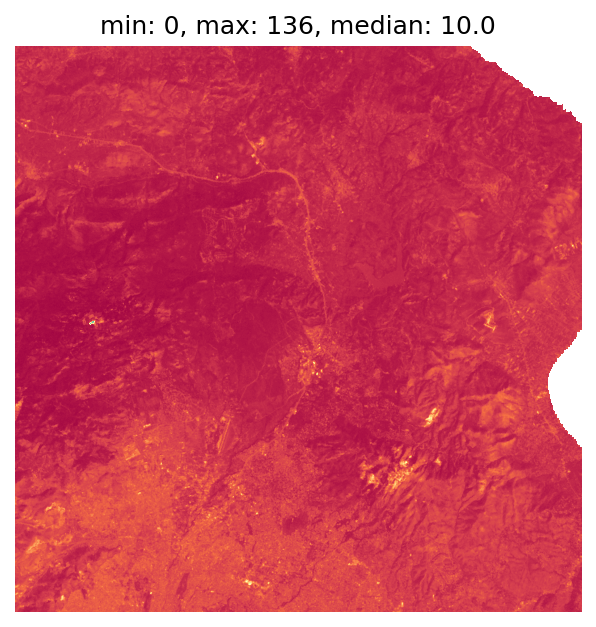

In [7]:

from eumap import plotter
import numpy as np

# in case of plots not appearing properly in Jupyter
%matplotlib inline

data_min = data.min()
data_max = data.max()
data_median = np.median(data)

nodata = raster.nodata

plotter.plot_rasters(
    data,
    titles=f'min: {data_min}, max: {data_max}, median: {data_median}',
    figsize=5,
    nodata=nodata,
    vmin=int(data_min),
    vmax=int(data_max),
)

Aside from providing an easy way to deal with arrays and access to linear algebra, `numpy` supplies highly performant vectorized operations using BLAS libraries like MKL and OpenBLAS under the hood.

Let's find out where our data falls outside the interval from the 20th to the 80th percentile. Comparing an array with a number (or another array with compatible dimensions) yields an array of boolean elements. We can perform operations on these boolean arrays with Python's bitwise boolean operators.

In [8]:

low, high = np.percentile(data, [20, 80])
print('P5:', low)
print('P95:', high)

hi_index = data > high
lo_index = data < low
nodata_index = hi_index | lo_index
print('index:', nodata_index)

pct_outside = 100 * nodata_index.sum() / nodata_index.size
print('% of data outside of bounds:', pct_outside.round(2))

P5: 6.0
P95: 15.0
index: [[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [False  True  True ... False False False]
 [False False  True ... False False False]
 [False False  True ... False False False]]
% of data outside of bounds: 32.21


Using the index we can now alter the out-of-bounds pixels to the nodata value.

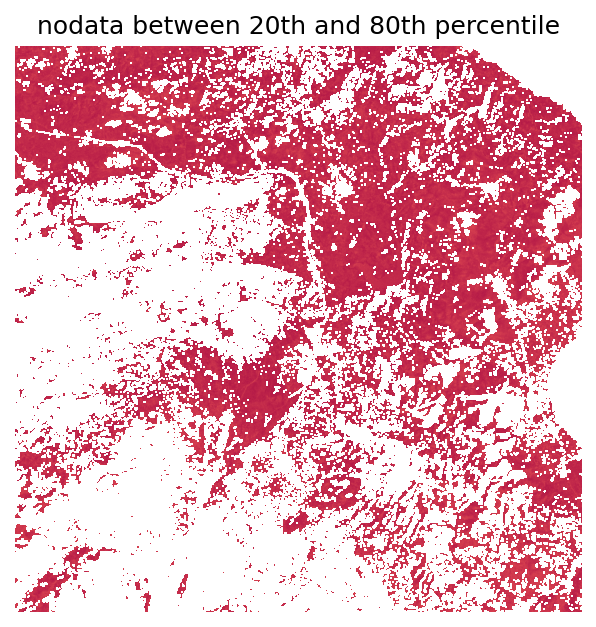

In [9]:

new_data = data.copy()
new_data[nodata_index] = nodata

plotter.plot_rasters(
    new_data,
    titles=f'nodata between 20th and 80th percentile',
    figsize=5,
    nodata=nodata,
    vmin=int(data_min),
    vmax=int(data_max),
)

...or clip the data to the interval.

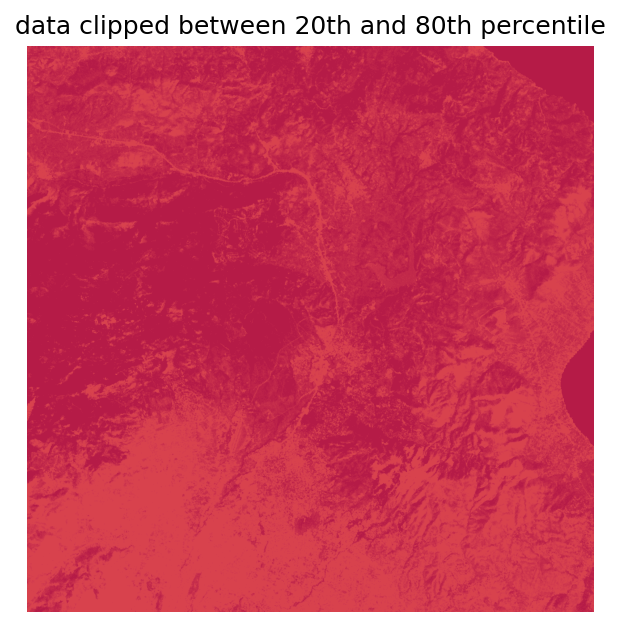

In [10]:

new_data[lo_index] = low
new_data[hi_index] = high

plotter.plot_rasters(
    new_data,
    titles=f'data clipped between 20th and 80th percentile',
    figsize=5,
    nodata=nodata,
    vmin=int(data_min),
    vmax=int(data_max),
)

Notice that the areas previously containing no data are now filled with valid values. That's because we didn't account for that nodata mask. We can produce an index by either comparing the data array to the nodata value, or better yet, using the `read_masks()` method of the `DatasetReader`. While nodata masks can sometimes be accounted for later on, it is beneficial to conserve resources by avoiding computation on nodata altogether.

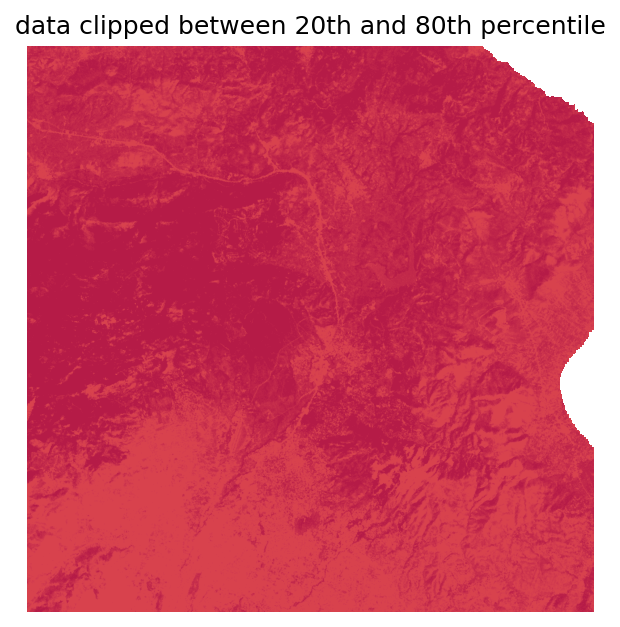

In [11]:

data_mask = raster.read_masks(1).astype(bool)
data_only = data[data_mask].copy()

hi_index = data_only > high
lo_index = data_only < low

data_only[lo_index] = low
data_only[hi_index] = high

new_data[:] = nodata
new_data[data_mask] = data_only

plotter.plot_rasters(
    new_data,
    titles=f'data clipped between 20th and 80th percentile',
    figsize=5,
    nodata=nodata,
    vmin=int(data_min),
    vmax=int(data_max),
)

Now let's open a folder and write our new data to a file. To open a file in write mode, we need to provide additional arguments, such as raster width and height in pixels, driver, etc. A transformation matrix and CRS are also required if we want our raster to be properly geospatially referenced. Luckily, all of this is contained in the `profile` `dict` of our `DatasetReader`. Since we have not changed any properties of the raster other than the data itself, we can pass the entire `profile` to the `DatasetWriter` as `**kwargs`.

Note that `rasterio` readers and writers can also be used as context managers (as one would use `open()` from the Python standard library).

In [12]:
import os

out_dir = data_home/'session_2_outputs'
os.makedirs(out_dir, exist_ok=True)

out_path = out_dir/'raster.tif'

with rio.open(out_path, 'w', **raster.profile) as dst:
    print(dst)
    dst.write(new_data, 1)

<open DatasetWriter name='/home/luka/ODSE_workdir/data/session_2_outputs/raster.tif' mode='w'>


`plotter.plot_rasters()` can also be called with dataset filepaths instead of data arrays. When used this way we do not have to provide the `nodata` argument, as it will be read from the file automatically.

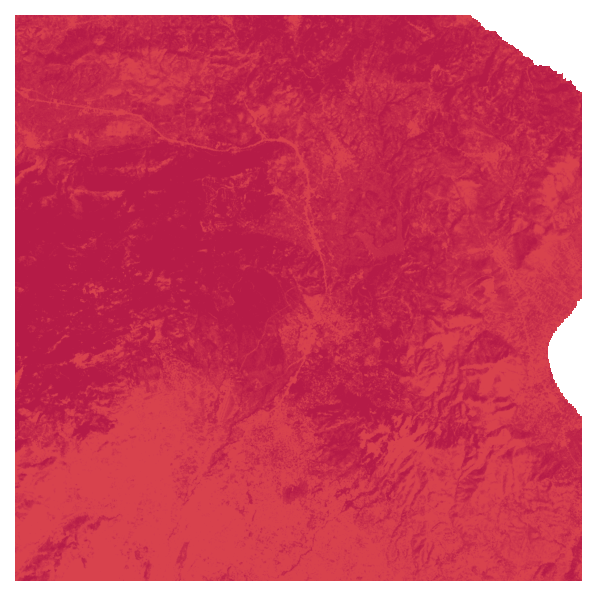

In [13]:

plotter.plot_rasters(
    out_path,
    figsize=5,
    vmin=int(data_min),
    vmax=int(data_max),
)

## Vector manipulation

For vector reading/writing and manipulation, we will use `geopandas`, a library that extends data frames with capabilities for processing geometries in a vectorized manner. `geopandas` internally uses `fiona` for I/O and `shapely` (and more recently `pygeos`) for handling geometry primitives.

Let's load the sample land cover points provided for the workshop and inspect the data.

In [14]:

import geopandas as gp

points = gp.read_file(data_home/'land_cover_samples.gpkg')

print('CRS:', points.crs)
print('N points:', points.index.size)

points

CRS: epsg:3035
N points: 1991


,uid,sample_id,lucas,survey_date,clc_class,confidence,tile_id,dtm_cost.distance.to.coast_gedi.grass.gis_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2,dtm_slope.percent_gedi.eml_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2,dtm_hillshade.multid_gedi.gdal_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2,...,lcv_thermal_landsat.glad.ard_p25_30m_0..0cm_.12.02...03.20_eumap_epsg3035_v1.1,lcv_thermal_landsat.glad.ard_p50_30m_0..0cm_.03.21...06.24_eumap_epsg3035_v1.1,lcv_thermal_landsat.glad.ard_p25_30m_0..0cm_.03.21...06.24_eumap_epsg3035_v1.1,lcv_thermal_landsat.glad.ard_p75_30m_0..0cm_.09.13...12.01_eumap_epsg3035_v1.1,lcv_thermal_landsat.glad.ard_p75_30m_0..0cm_.12.02...03.20_eumap_epsg3035_v1.1,lcv_thermal_landsat.glad.ard_p75_30m_0..0cm_.06.25...09.12_eumap_epsg3035_v1.1,lcv_thermal_landsat.glad.ard_p75_30m_0..0cm_.03.21...06.24_eumap_epsg3035_v1.1,clc_class_name,survey_year,geometry
0,1,1043933,False,2000-06-30T00:00:00,112.0,85.0,14580,16.0,3.0,179.0,...,182.0,184.0,184.0,184.0,182.0,184.0,185.0,Discontinuous urban fabric,2000,POINT (4029228.465 3213721.960)
1,2,1044143,False,2000-06-30T00:00:00,112.0,85.0,14580,17.0,9.0,174.0,...,182.0,185.0,185.0,184.0,184.0,185.0,185.0,Discontinuous urban fabric,2000,POINT (4026356.067 3226174.095)
2,3,1045508,False,2000-06-30T00:00:00,142.0,85.0,14580,26.0,5.0,184.0,...,182.0,182.0,182.0,182.0,182.0,182.0,182.0,Sport and leisure facilities,2000,POINT (4040332.136 3232426.480)
3,4,1047826,False,2000-06-30T00:00:00,121.0,85.0,14580,20.0,2.0,179.0,...,181.0,184.0,184.0,184.0,181.0,184.0,184.0,Industrial or commercial units,2000,POINT (4043139.050 3210780.235)
4,5,1047851,False,2000-06-30T00:00:00,121.0,85.0,14580,18.0,18.0,167.0,...,183.0,184.0,184.0,183.0,183.0,184.0,185.0,Industrial or commercial units,2000,POINT (4031326.376 3214389.790)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,1987,1969703,False,2018-06-30T00:00:00,324.0,85.0,5606,30.0,65.0,208.0,...,188.0,189.0,188.0,190.0,190.0,190.0,189.0,Transitional woodland-shrub,2018,POINT (5529944.553 1799948.030)
1987,1988,1973479,False,2018-06-30T00:00:00,411.0,85.0,5606,1.0,5.0,184.0,...,188.0,187.0,186.0,189.0,189.0,188.0,187.0,Inland marshes,2018,POINT (5549833.044 1787886.590)
1988,1989,1973669,False,2018-06-30T00:00:00,512.0,85.0,5606,77.0,5.0,184.0,...,185.0,183.0,183.0,186.0,187.0,184.0,184.0,Water bodies,2018,POINT (5540375.986 1788516.395)
1989,1990,2229815,False,2018-06-30T00:00:00,242.0,85.0,5606,97.0,19.0,169.0,...,188.0,188.0,188.0,188.0,188.0,190.0,189.0,Complex cultivation patter,2018,POINT (5529408.859 1782531.095)


We can compare the extent of the points with that of our sample raster. We can use `shapely` to construct polygons from the bounding box coordinates of both datasets. `shapely` interacts nicely with Jupyter and visualizes geometries on output.

raster extent: POLYGON ((5550000 1770010, 5550000 1800010, 5520000 1800010, 5520000 1770010, 5550000 1770010))
points extent: POLYGON ((5550000 1770025.925, 5550000 3240000, 4020000 3240000, 4020000 1770025.925, 5550000 1770025.925))


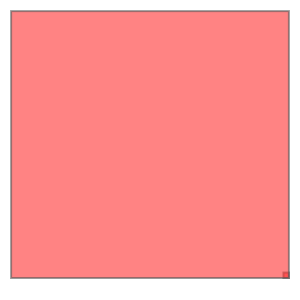

In [15]:

from shapely.geometry import box, MultiPolygon

raster_extent = box(*raster.bounds)
print('raster extent:', raster_extent)

points_bounds = points.cascaded_union.bounds
points_extent = box(*points_bounds)
print('points extent:', points_extent)

MultiPolygon([raster_extent, points_extent])

We can see the extent of the points is much larger than that of the raster, so we will utilize `geopandas` to perform a vectorized intersection check over the points. This produces a boolean array which we can use to index only the points inside the raster bounds.

N points: 899


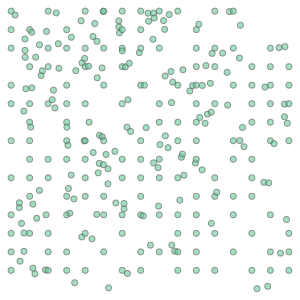

In [16]:

point_subset_index = points.intersects(raster_extent)

point_subset = points[point_subset_index]

print('N points:', point_subset.index.size)
point_subset.cascaded_union

We can now write our reduced point dataset to a file. Like `rasterio` (or `GDAL`), `geopandas` has support for various drivers. Here we will output the points to GeoJSON.

In [17]:

point_subset.to_file(
    out_dir/'clipped_points.geojson',
    driver='GeoJSON'
)

## Computing a raster time series

Let's compute a spring NDVI timeseries for our tile from LANDSAT composites for the spring season for years 2000 to 2020. We can use `eumap.raster.read_rasters()` for a multithreaded read of multiple datasets into a single array. `read_rasters()` behaves in a time series friendly manner, stacking all layers into a multiband image. It also takes care of nodata masks, filling them with NaN.

In [18]:

from eumap.raster import read_rasters

red_files = find_files(tile_dir, 'lcv/lcv_red_landsat.glad.ard_p50*03.21*.tif')
nir_files = find_files(tile_dir, 'lcv/lcv_nir_landsat.glad.ard_p50*03.21*.tif')

red, __ = read_rasters(raster_files=red_files)
nir, __ = read_rasters(raster_files=nir_files)

print('array shapes:', red.shape, nir.shape)

array shapes: (1000, 1000, 21) (1000, 1000, 21)


We can now use the stacked data to compute the entire NDVI series at once. We will then plot the series at a single pixel.

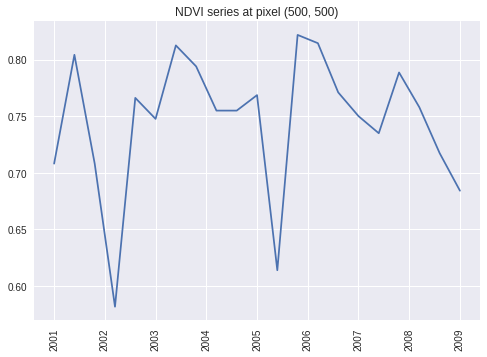

In [19]:

import matplotlib.pyplot as plt
plt.style.use('seaborn')

ndvi = (nir - red) / (nir + red)

years = [*range(2000, 2021)]

def plot_series(data, index):
    xi, yi = index
    fig, ax = plt.subplots()
    ax.plot(years, data[yi,xi,:])
    ax.set_title(f'NDVI series at pixel {index}')
    ax.set_xticklabels(years, rotation=90)

plot_series(ndvi, (500, 500))

We can also use `plotter` to plot the series over the entire tile, but first we have to unstack the image into separate arrays for each year.

In [20]:

ndvi = np.moveaxis(ndvi, -1, 0)
ndvi.shape

(21, 1000, 1000)

We will now plot the series over the last five years.

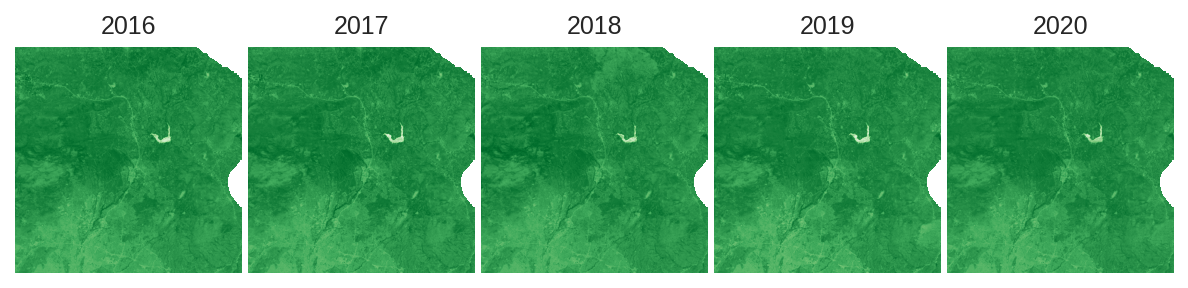

In [21]:

plotter.plot_rasters(
    *ndvi.astype(np.float32)[-5:],
    figsize=10,
    titles=years[-5:],
    cmaps='Greens',
    vmin=-1,
    vmax=1,
)

Let's compute for each year the NDVI difference to the previous one and plot the results for the last five years.

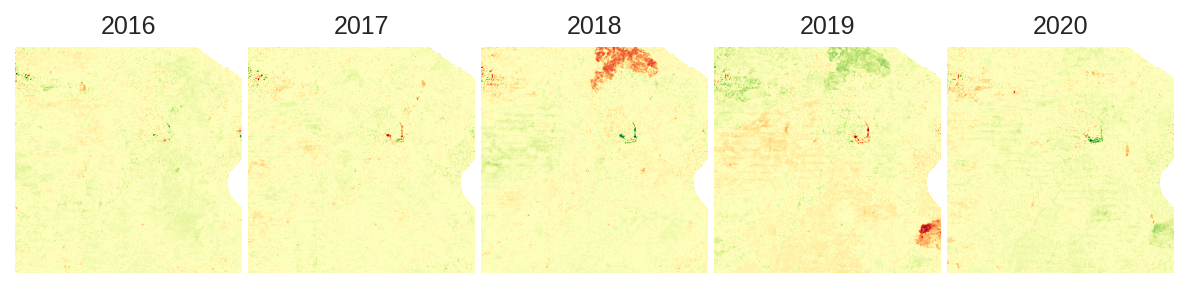

In [22]:

diff = ndvi[1:] - ndvi[:-1]

plotter.plot_rasters(
    *diff.astype(np.float32)[-5:],
    figsize=10,
    titles=years[-5:],
    cmaps='RdYlGn',
    vmin=-.5,
    vmax=.5,
)

We can use `save_rasters()` to batch write results for all the years in parallel, analogue to `read_rasters()`. `save_rasters()` takes series as multiband images, so we have to stack our `diff` array.

In [23]:

from eumap.raster import save_rasters

out_files = [out_dir/f'ndvi_diff/ndvi_diff_{year}.tif' for year in years[1:]]

save_rasters(
    raster.name,
    out_files,
    np.stack(diff, -1).astype(np.float32),
    dtype='float32',
    nodata=-99.,
)

[PosixPath('/home/luka/ODSE_workdir/data/session_2_outputs/ndvi_diff/ndvi_diff_2001.tif'),
 PosixPath('/home/luka/ODSE_workdir/data/session_2_outputs/ndvi_diff/ndvi_diff_2002.tif'),
 PosixPath('/home/luka/ODSE_workdir/data/session_2_outputs/ndvi_diff/ndvi_diff_2003.tif'),
 PosixPath('/home/luka/ODSE_workdir/data/session_2_outputs/ndvi_diff/ndvi_diff_2004.tif'),
 PosixPath('/home/luka/ODSE_workdir/data/session_2_outputs/ndvi_diff/ndvi_diff_2005.tif'),
 PosixPath('/home/luka/ODSE_workdir/data/session_2_outputs/ndvi_diff/ndvi_diff_2006.tif'),
 PosixPath('/home/luka/ODSE_workdir/data/session_2_outputs/ndvi_diff/ndvi_diff_2007.tif'),
 PosixPath('/home/luka/ODSE_workdir/data/session_2_outputs/ndvi_diff/ndvi_diff_2008.tif'),
 PosixPath('/home/luka/ODSE_workdir/data/session_2_outputs/ndvi_diff/ndvi_diff_2009.tif'),
 PosixPath('/home/luka/ODSE_workdir/data/session_2_outputs/ndvi_diff/ndvi_diff_2010.tif'),
 PosixPath('/home/luka/ODSE_workdir/data/session_2_outputs/ndvi_diff/ndvi_diff_2011.tif'),

Let's overlay the results with our point subset. `eumap` provides a parallelized way of overlaying points with rasters.

In [24]:

from eumap.mapper import SpaceOverlay
from datetime import datetime
overlay_points = point_subset

overlay = SpaceOverlay(
    point_subset[['geometry']],
    out_files,
).run()

[11:23:47] 1/20 ndvi_diff_2003
[11:23:47] 2/20 ndvi_diff_2001
[11:23:47] 3/20 ndvi_diff_2012
[11:23:47] 4/20 ndvi_diff_2008
[11:23:48] 5/20 ndvi_diff_2007
[11:23:48] 6/20 ndvi_diff_2010
[11:23:48] 7/20 ndvi_diff_2011
[11:23:48] 8/20 ndvi_diff_2013
[11:23:48] 9/20 ndvi_diff_2014
[11:23:48] 10/20 ndvi_diff_2009
[11:23:48] 11/20 ndvi_diff_2006
[11:23:48] 12/20 ndvi_diff_2016
[11:23:48] 13/20 ndvi_diff_2004
[11:23:48] 14/20 ndvi_diff_2015
[11:23:48] 15/20 ndvi_diff_2002
[11:23:48] 16/20 ndvi_diff_2005
[11:23:48] 17/20 ndvi_diff_2017
[11:23:48] 18/20 ndvi_diff_2019
[11:23:48] 19/20 ndvi_diff_2020
[11:23:48] 20/20 ndvi_diff_2018


Each point will now have attached the time series of NDVI differences.

In [25]:

overlay

,geometry,overlay_id,ndvi_diff_2003,ndvi_diff_2001,ndvi_diff_2012,ndvi_diff_2008,ndvi_diff_2007,ndvi_diff_2010,ndvi_diff_2011,ndvi_diff_2013,...,ndvi_diff_2006,ndvi_diff_2016,ndvi_diff_2004,ndvi_diff_2015,ndvi_diff_2002,ndvi_diff_2005,ndvi_diff_2017,ndvi_diff_2019,ndvi_diff_2020,ndvi_diff_2018
1092,POINT (5527636.911 1775612.990),1,0.060669,0.036255,0.013672,-0.022583,0.015259,-0.035522,-0.012573,-0.024292,...,-0.051880,0.063843,-0.003052,-0.108765,-0.036255,0.026733,-0.023804,-0.082397,0.036377,0.068237
1093,POINT (5534267.103 1777884.970),2,0.036377,0.042847,0.020874,-0.034058,0.052856,-0.032227,0.001343,-0.012939,...,-0.021118,0.118652,0.039673,-0.013794,-0.079224,-0.016602,-0.036987,-0.055908,0.020386,0.052124
1094,POINT (5521127.782 1777073.320),3,-0.095703,0.000000,0.029785,-0.030518,0.043945,-0.044189,0.014404,0.029297,...,0.034668,-0.060547,0.062012,0.049072,0.016357,-0.039551,-0.025391,0.037842,0.010742,-0.029785
1095,POINT (5547295.036 1781503.735),4,0.020996,0.011963,0.005859,0.018311,0.048584,0.006836,0.027100,-0.039795,...,-0.048340,-0.036621,0.000000,-0.000732,-0.057129,0.030273,-0.037109,0.013184,0.029785,0.005615
1096,POINT (5537457.732 1792335.345),5,-0.030518,0.064697,0.081543,-0.045410,0.045166,-0.047119,-0.045898,0.010742,...,0.082764,0.044678,0.046875,0.035156,-0.064697,-0.102783,-0.010010,-0.083496,0.068848,0.042480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,POINT (5529944.553 1799948.030),895,-0.034180,0.021240,0.044434,-0.015381,-0.015137,0.023438,-0.022461,0.009277,...,0.001465,-0.033203,0.063477,0.025391,-0.021240,0.020996,-0.008057,0.008057,-0.008057,0.000000
1987,POINT (5549833.044 1787886.590),896,-0.068115,0.083008,0.061523,-0.077637,0.042480,-0.070801,-0.006348,-0.075684,...,0.192139,-0.026367,0.186035,0.012695,-0.349854,-0.160889,0.040039,-0.005859,-0.043457,0.025879
1988,POINT (5540375.986 1788516.395),897,-0.495117,0.000000,0.039612,-0.114014,0.500000,-0.107178,-0.051941,-0.630371,...,-0.777344,0.200195,0.566406,-0.547363,0.228516,-0.055664,-0.314453,-0.068359,0.389893,-0.035645
1989,POINT (5529408.859 1782531.095),898,-0.044678,-0.012939,-0.042725,0.044189,0.025146,0.064209,0.023682,0.034424,...,-0.031250,-0.030762,-0.025635,0.068359,0.039062,0.019043,0.013184,0.057129,-0.023926,-0.032227


Let's plot the series at one of the points.

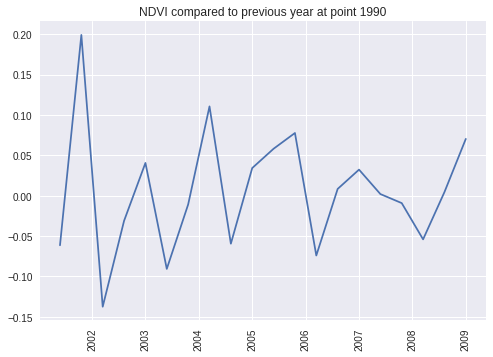

In [26]:

def plot_series(point_id):
    diff_cols = sorted(overlay.columns[2:])
    fig, ax = plt.subplots()
    series = overlay.loc[point_id][diff_cols].values
    ax.plot(years[1:], series)
    ax.set_title(f'NDVI compared to previous year at point {point_id}')
    ax.set_xticklabels(years[1:], rotation=90)

plot_series(1990)

## Raster block processing

`rasterio` allows for rasters to be read from within a defined window.

'''

#%%

from rasterio.windows import Window

window = Window(
    col_off=0,
    row_off=0,
    width=5,
    height=5,
)

window_data = raster.read(1, window=window)

window_data

#%%

'''
Cloud optimized GeoTIFFs are internally organized into blocks with local compression. Let's check the block number of our raster.

In [27]:

block_windows = [*raster.block_windows()]

print('N blocks:', len(block_windows))

N blocks: 125


When reading a window from a raster, all blocks intersecting the window have to be read and decompressed. So if we read a single raster in parallel but only at windows corresponding to block boundaries, we minimize read time. `eumap.parallel.blocks` leverages this to enable efficient processing of large datasets, which allows for both faster processing on large hardware infrastructure and for long-running processing with limited resources.

We will compute NDVI for a single season within the boundary of our raster, but this time from pan-european LANDSAT mosaics hosted in S3 buckets.

To do this we first have to convert the geometry into the GeoJSON schema.

In [28]:

from shapely.geometry import mapping

red_url = 'http://s3.eu-central-1.wasabisys.com/eumap/landsat/landsat_ard_20180625_20180912_red_p50.tif'
nir_url = 'http://s3.eu-central-1.wasabisys.com/eumap/landsat/landsat_ard_20180625_20180912_nir_p50.tif'

with rio.open(red_url) as src:
    print('raster size:', src.shape)

geometry = mapping(raster_extent)

print(geometry)

raster size: (151000, 188000)
{'type': 'Polygon', 'coordinates': (((5550000.0, 1770010.0), (5550000.0, 1800010.0), (5520000.0, 1800010.0), (5520000.0, 1770010.0), (5550000.0, 1770010.0)),)}


We will now initialize the reader and writer and define NDVI as a function.

In [29]:

from eumap.parallel.blocks import RasterBlockReader, RasterBlockWriter

def calc_ndvi(red, nir):
    return (nir - red) / (nir + red)

reader = RasterBlockReader(reference_file=red_url)
writer = RasterBlockWriter(reader=reader)

We can now start the block-wise processing and write the result to a file.

In [30]:

out_file = out_dir/'ndvi_blocks.tif'

writer.write(
    src_path=[red_url, nir_url],
    dst_path=out_file,
    geometry=geometry,
    block_func=calc_ndvi,
    nodata=-9999.,
    dtype='float32',
)

reader using 3 threads


Let's check the results.

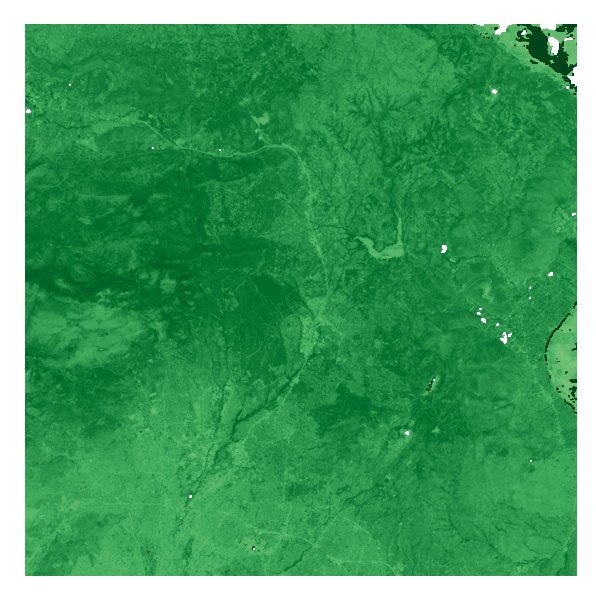

In [31]:

plotter.plot_rasters(
    out_file,
    cmaps='Greens',
    figsize=5,
    vmin=-1,
    vmax=1,
)

## ODS data catalogue

`eumap.datasets.Catalogue` provides some abstraction over the ODS data catalogue. It provides a search utility to access dataset URLs.

In [32]:

from eumap.datasets import Catalogue

cat = Catalogue(use_csw=False)
results = cat.search('ndvi')

results

ResourceCollection of 82 total assets:

title:       NDVI trend slope
abstract:    ndvi: Slope of NDVI (four seasons between 2000 and 2019) derived by OLS regression over a deseasonalized time series (Season-Trend decomposition using LOESS). The std. error of the model was considered as uncertainty.
theme:       Land cover, land use and administrative data
resources:   ['https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_ndvi_landsat.glad.trend.slope_p50_30m_0..0cm_2000..2019_eumap_epsg3035_v1.0.tif']
N_resources: 1

title:       NDVI trend slope R2
abstract:    ndvi: R2 of OLS regression calculated over a deseasonalized time series (Season-Trend decomposition using LOESS) for NDVI (four seasons between 2000 and 2019).
theme:       Land cover, land use and administrative data
resources:   ['https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_ndvi_landsat.glad.trend.ols_r2_30m_0..0cm_2000..2019_eumap_epsg3035_v1.0.tif']
N_resources: 1

title:       NDVI Landsat (quarterly)
abstract:   

We can ommit unwanted results with the `exclude` keyword argument

In [33]:

results = cat.search('ndvi', exclude=['trend'])

results

ResourceCollection of 80 total assets:

title:       NDVI Landsat (quarterly)
abstract:    ndvi: NDVI time-series, derived from the Landsat quarterly temporal composites.
theme:       Land cover, land use and administrative data
resources:   ['https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_200806_eumap_epsg3035_v1.0.tif', 'https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_200803_eumap_epsg3035_v1.0.tif', 'https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_200712_eumap_epsg3035_v1.0.tif', 'https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_200709_eumap_epsg3035_v1.0.tif', 'https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_200706_eumap_epsg3035_v1.0.tif', 'https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_ndvi_landsat.glad.ard_p50_30m_0..0cm_200703_eumap_epsg3035_v1.0.tif', 'https://s3.eu-cent

...and also search by year.

In [34]:

results = cat.search(
    'ndvi',
    exclude=['trend'],
    years=[2019]
)

Since the results behave more or less like regular Python strings, we can sort them into a time series and read with `read_rasters`. We will read the window corresponding to our test raster

In [35]:
from rasterio.windows import from_bounds

results = sorted(results)

ref = rio.open(results[0])

window = from_bounds(
    *raster_extent.bounds,
    transform=ref.transform,
)

q_ndvi, __ = read_rasters(
    raster_files=[*map(str, results)],
    spatial_win=window,
    dtype=ref.profile['dtype'],
)

...and plot the results.

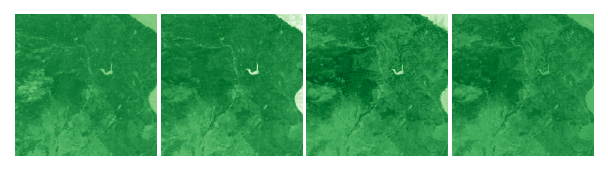

In [36]:

plotter.plot_rasters(
    *np.moveaxis(q_ndvi, -1, 0),
    figsize=5,
    cmaps='Greens',
    nodata=ref.nodata,
    vmin=int(q_ndvi.min()),
    vmax=int(q_ndvi.max()),
)
